这个数据是关于食物营养成分的。存储格式是JSON，看起来像这样：
```
{
    "id": 21441, 
    "description": "KENTUCKY FRIED CHICKEN, Fried Chicken, EXTRA CRISPY, Wing, meat and skin with breading", 
    "tags": ["KFC"], 
    "manufacturer": "Kentucky Fried Chicken", 
    "group": "Fast Foods", 
    "portions": [ 
        { "amount": 1, 
          "unit": "wing, with skin", 
          "grams": 68.0
        }
        ...
      ],
    "nutrients": [ 
      { "value": 20.8, 
        "units": "g", 
        "description": "Protein", 
        "group": "Composition" 
      },
      ...
     ]
}
```
每种食物都有一系列特征，其中有两个list，protions和nutrients。我们必须把这样的数据进行处理，方便之后的分析。

这里使用python内建的json模块：

In [1]:
import pandas as pd
import numpy as np
import json

In [2]:
pd.options.display.max_rows = 10

In [3]:
db = json.load(open('../data/usda_food/database.json'))

In [4]:
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [5]:
db[0]['nutrients'][0]

{'description': 'Protein',
 'group': 'Composition',
 'units': 'g',
 'value': 25.18}

In [6]:
nutrients = pd.DataFrame(db[0]['nutrients'])
nutrients

,description,group,units,value
0,Protein,Composition,g,25.180
1,Total lipid (fat),Composition,g,29.200
2,"Carbohydrate, by difference",Composition,g,3.060
3,Ash,Other,g,3.280
4,Energy,Energy,kcal,376.000
...,...,...,...,...
157,Serine,Amino Acids,g,1.472
158,Cholesterol,Other,mg,93.000
159,"Fatty acids, total saturated",Other,g,18.584
160,"Fatty acids, total monounsaturated",Other,g,8.275


In [7]:
info_keys = ['description', 'group', 'id', 'manufacturer']
info = pd.DataFrame(db, columns=info_keys)
info[:5]

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [8]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
description     6636 non-null object
group           6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [9]:
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Name: group, dtype: int64

这里我们对所有的nutrient数据做一些分析，把每种食物的nutrient部分组合成一个大表格。首先，把每个食物的nutrient列表变为DataFrame，添加一列为id，然后把id添加到DataFrame中，接着使用concat联结到一起：

In [10]:
# 先创建一个空DataFrame用来保存最后的结果
# 这部分代码运行时间较长，请耐心等待
nutrients_all = pd.DataFrame()

for food in db:
    nutrients = pd.DataFrame(food['nutrients'])
    nutrients['id'] = food['id']
    nutrients_all = nutrients_all.append(nutrients, ignore_index=True)

In [11]:
nutrients_all

,description,group,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
...,...,...,...,...,...
389350,"Vitamin B-12, added",Vitamins,mcg,0.000,43546
389351,Cholesterol,Other,mg,0.000,43546
389352,"Fatty acids, total saturated",Other,g,0.072,43546
389353,"Fatty acids, total monounsaturated",Other,g,0.028,43546


这个DataFrame中有一些重复的部分，看一下有多少重复的行：

In [12]:
nutrients_all.duplicated().sum()

14179

把重复的部分去掉：

In [13]:
nutrients_all = nutrients_all.drop_duplicates()
nutrients_all

,description,group,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
...,...,...,...,...,...
389350,"Vitamin B-12, added",Vitamins,mcg,0.000,43546
389351,Cholesterol,Other,mg,0.000,43546
389352,"Fatty acids, total saturated",Other,g,0.072,43546
389353,"Fatty acids, total monounsaturated",Other,g,0.028,43546


为了与info_keys中的group和descripton区别开，我们把列名更改一下：

In [14]:
col_mapping = {'description': 'food',
               'group': 'fgroup'}

In [15]:
info = info.rename(columns=col_mapping, copy=False)
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
food            6636 non-null object
fgroup          6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [16]:
col_mapping = {'description' : 'nutrient',
               'group': 'nutgroup'}

In [17]:
nutrients_all = nutrients_all.rename(columns=col_mapping, copy=False)
nutrients_all

,nutrient,nutgroup,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
...,...,...,...,...,...
389350,"Vitamin B-12, added",Vitamins,mcg,0.000,43546
389351,Cholesterol,Other,mg,0.000,43546
389352,"Fatty acids, total saturated",Other,g,0.072,43546
389353,"Fatty acids, total monounsaturated",Other,g,0.028,43546


上面所有步骤结束后，我们可以把info和nutrients_all合并（merge）：

In [18]:
ndata = pd.merge(nutrients_all, info, on='id', how='outer')
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 375175
Data columns (total 8 columns):
nutrient        375176 non-null object
nutgroup        375176 non-null object
units           375176 non-null object
value           375176 non-null float64
id              375176 non-null int64
food            375176 non-null object
fgroup          375176 non-null object
manufacturer    293054 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ MB


In [19]:
ndata.iloc[30000]

nutrient                                       Glycine
nutgroup                                   Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

我们可以对食物群（food group）和营养类型（nutrient type）分组后，对中位数进行绘图：

In [20]:
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)

In [21]:
%matplotlib inline

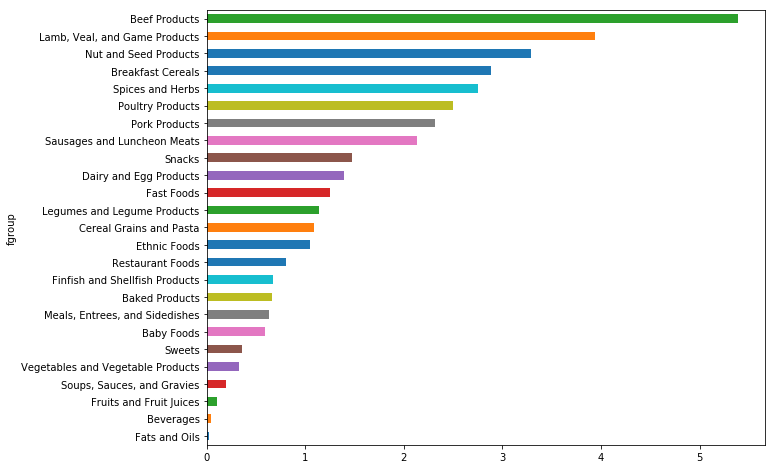

In [22]:
result['Zinc, Zn'].sort_values().plot(kind='barh', figsize=(10, 8))

我们还可以找到每一种营养成分含量最多的食物是什么：

In [23]:
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

get_maximum = lambda x: x.loc[x.value.idxmax()]
get_minimum = lambda x: x.loc[x.value.idxmin()]

max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

# make the food a little smaller
max_foods.food = max_foods.food.str[:50]

In [24]:
max_foods.loc['Amino Acids']['food']

nutrient
Alanine                          Gelatins, dry powder, unsweetened
Arginine                              Seeds, sesame flour, low-fat
Aspartic acid                                  Soy protein isolate
Cystine               Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                  Soy protein isolate
                                       ...                        
Serine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Threonine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Tryptophan        Sea lion, Steller, meat with fat (Alaska Native)
Tyrosine         Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Valine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Name: food, Length: 19, dtype: object